In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/ygrene/수방이작업실/

/content/drive/.shortcut-targets-by-id/1PK1OaPryLfu2eB3iega5z40yHx_idzuf/ygrene/수방이작업실


In [ ]:
import numpy as np 
import pandas as pd
from time import time 
import pprint

import warnings
warnings.filterwarnings('ignore')


import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('./solar_slide_timeseriesed.csv',index_col=0)
data_x = data[data['datetime'] < '2022-05-01']
data_y = data_x['target']
data_x = data_x.iloc[:,2:]

test_x = data[(data['datetime'] >= '2022-05-01') & (data['datetime'] < '2022-07-01')]
test_x.drop(['datetime','target'], axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(data_x, data_y, test_size=0.1, random_state=1234, shuffle=True)

In [ ]:
from sklearn.preprocessing import  MinMaxScaler

mm_scaler = MinMaxScaler()
mm_scaler.fit(train_x)
train_x_scaled = mm_scaler.transform(train_x)
val_x_scaled = mm_scaler.transform(val_x)
test_x_scaled = mm_scaler.transform(test_x)

train_y = np.array(train_y)
val_y = np.array(val_y)

In [ ]:
def NMAE(true, pred, nominal=1100):
    absolute_error = np.abs(true - pred)
    absolute_error /= nominal
    target_idx = np.where(true >= nominal*0.1)
    return 100 * np.array([absolute_error[i] for i in target_idx]).mean()

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 82 kB/s 


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import Lars, LassoLars, OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge, ARDRegression, PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
seed=1234

estimator1 = LGBMRegressor(n_estimators= 4000, reg_alpha= 0.00606917974144699, reg_lambda= 0.618213020887822, 
                           colsample_bytree= 0.9, subsample= 0.8, learning_rate= 0.019,max_depth= 25, num_leaves= 500, 
                           min_child_samples= 300, min_data_per_groups= 100, random_state=seed)

estimator2 = CatBoostRegressor(verbose=False, random_state=seed)
estimator3 = XGBRegressor(n_jobs=-1, random_state=seed)
# estimator4 = ExtraTreeRegressor(random_state=seed)
# estimator5 = RandomForestRegressor(n_jobs=-1, random_state=seed)

In [ ]:
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_absolute_error 

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):

    kf = KFold(n_splits=n_folds, shuffle=False)

    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):

        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        

        model.fit(X_tr , y_tr)       

        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)

        test_pred[:, folder_counter] = model.predict(X_test_n)
            

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    

    return train_fold_pred , test_pred_mean

In [ ]:
es1_train, es1_test = get_stacking_base_datasets(estimator1, train_x_scaled, train_y, val_x_scaled, 7)
es2_train, es2_test = get_stacking_base_datasets(estimator2, train_x_scaled, train_y, val_x_scaled, 7)
es3_train, es3_test = get_stacking_base_datasets(estimator3, train_x_scaled, train_y, val_x_scaled, 7)
# es4_train, es4_test = get_stacking_base_datasets(estimator4, train_x_scaled, train_y, val_x_scaled, 7)
# es5_train, es5_test = get_stacking_base_datasets(estimator5, train_x_scaled, train_y, val_x_scaled, 7)

LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
CatBoostRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
[06:54:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  1  시작 
[06:54:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  2  시작 
[06:54:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  3  시작 
[06:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  4  시작 
[06:54:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now depre

In [ ]:
Stack_final_X_train = np.concatenate((es1_train, es2_train, es3_train), axis=1)
Stack_final_X_test = np.concatenate((es1_test, es2_test, es3_test), axis=1)
print('원본 학습 피처 데이터 Shape:',train_x_scaled.shape, '원본 검증 피처 Shape:',val_x_scaled.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 검증 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (12916, 25) 원본 검증 피처 Shape: (1436, 25)
스태킹 학습 피처 데이터 Shape: (12916, 3) 스태킹 검증 피처 데이터 Shape: (1436, 3)


In [ ]:
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()
meta_model.fit(Stack_final_X_train, train_y)
stack_final = meta_model.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(NMAE(val_y, stack_final, 1100)))

최종 메타 모델의 예측 정확도: 7.6824


In [ ]:
stack_final = meta_model.predict(Stack_final_X_train)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(NMAE(train_y, stack_final, 1100)))

최종 메타 모델의 예측 정확도: 8.2124


# 추론

In [ ]:
es1_train, es1_test = get_stacking_base_datasets(estimator1, train_x_scaled, train_y, test_x_scaled, 7)
es2_train, es2_test = get_stacking_base_datasets(estimator2, train_x_scaled, train_y, test_x_scaled, 7)
es3_train, es3_test = get_stacking_base_datasets(estimator3, train_x_scaled, train_y, test_x_scaled, 7)
# es4_train, es4_test = get_stacking_base_datasets(estimator4, train_x_scaled, train_y, test_x_scaled, 7)
# es5_train, es5_test = get_stacking_base_datasets(estimator5, train_x_scaled, train_y, test_x_scaled, 7)

LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
CatBoostRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
[07:13:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  1  시작 
[07:13:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  2  시작 
[07:13:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  3  시작 
[07:13:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  4  시작 
[07:13:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now depre

In [ ]:
Stack_final_X_train = np.concatenate((es1_train, es2_train, es3_train), axis=1)
Stack_final_X_test = np.concatenate((es1_test, es2_test, es3_test), axis=1)
print('원본 학습 피처 데이터 Shape:',train_x_scaled.shape, '원본 검증 피처 Shape:',test_x_scaled.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 검증 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (12916, 25) 원본 검증 피처 Shape: (1464, 25)
스태킹 학습 피처 데이터 Shape: (12916, 3) 스태킹 검증 피처 데이터 Shape: (1464, 3)


In [ ]:
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()
meta_model.fit(Stack_final_X_train, train_y)
prediction = meta_model.predict(Stack_final_X_test)

In [ ]:
stack_final = meta_model.predict(Stack_final_X_train)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(NMAE(train_y, stack_final, 1100)))

최종 메타 모델의 예측 정확도: 8.2124


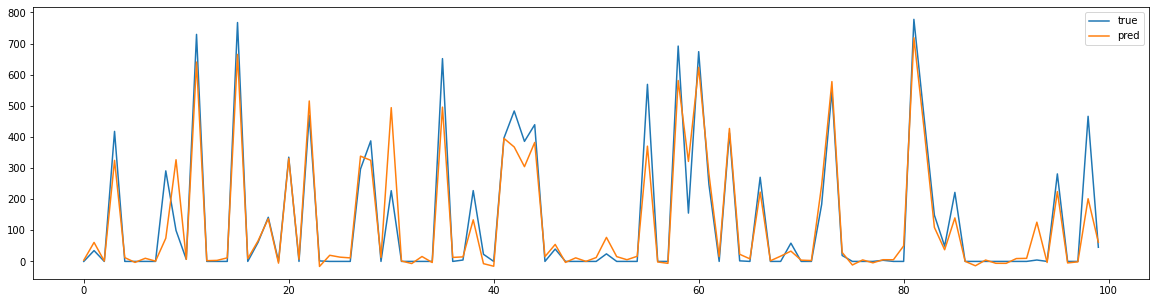

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train_y[:100], label='true')
plt.plot(stack_final[:100], label='pred')
plt.legend()
plt.show()

# 제출

In [ ]:
prediction_pred = pd.DataFrame(prediction)

prediction_pred.to_csv('../prediction_answer/yj_solar_slide_timeseriesed_stack_5.csv')